# Homework 2, *part 2* (60 points)

In this assignment you will build a heavy convolutional neural net (CNN) to solve Tiny ImageNet image classification. Try to achieve as high accuracy as possible.

## Deliverables

* This file,
* a "checkpoint file" from `torch.save(model.state_dict(), ...)` that contains model's weights (which a TA should be able to load to verify your accuracy).

## Grading

* 9 points for reproducible training code and a filled report below.
* 12 points for building a network that gets above 20% accuracy.
* 6.5 points for beating each of these milestones on the validation set:
  * 25.0%
  * 30.0%
  * 32.5%
  * 35.0%
  * 37.5%
  * 40.0%
    
## Restrictions

* Don't use pretrained networks.

## Tips

* One change at a time: never test several new things at once.
* Google a lot.
* Use GPU.
* Use regularization: L2, batch normalization, dropout, data augmentation.
* Use Tensorboard ([non-Colab](https://github.com/lanpa/tensorboardX) or [Colab](https://medium.com/@tommytao_54597/use-tensorboard-in-google-colab-16b4bb9812a6)) or a similar interactive tool for viewing progress.

In [1]:
import numpy as np
import tiny_imagenet
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torchvision
import torch
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
import operator
import matplotlib.pyplot as plt
from tqdm import trange
import PIL.Image as Image
from IPython import display
import numpy as np
import random
import time

In [3]:
tiny_imagenet.download(".")

.\tiny-imagenet-200 already exists, not downloading


Training and validation images are now in `tiny-imagenet-200/train` and `tiny-imagenet-200/val`.

In [4]:
batch_size = 100

train_transform = transforms.Compose([
        transforms.RandomRotation(5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees = 10, shear = 10, scale = (0.7, 1.05)),
        transforms.ToTensor()])
    
val_transform = transforms.Compose([
        transforms.ToTensor()])



data_train = torchvision.datasets.ImageFolder('tiny-imagenet-200/train', transform=train_transform)
data_val = torchvision.datasets.ImageFolder('tiny-imagenet-200/val', transform=val_transform)
train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,shuffle=True)

torch.Size([3, 64, 64])


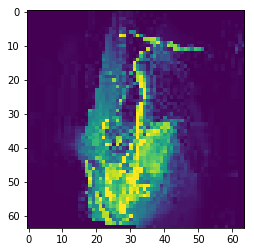

In [5]:
#Visualise to seee, if the dataloader works correctly
for X,y in train_loader:
    print(X[0].size())
    plt.imshow(np.array(X[0,0,:,:]))
    break

In [6]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

model = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64,kernel_size=3 ,stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(64),
                      nn.ReLU(inplace=True),
                      nn.MaxPool2d(kernel_size=3,padding=1,stride=2),
                      nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3 ,stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(128),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3 ,stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(128),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=128, out_channels=256,kernel_size=3 ,stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(256),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=256, out_channels=256,kernel_size=3 ,stride=2, padding=1, bias=False),
                      nn.BatchNorm2d(256),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(in_channels=256, out_channels=512,kernel_size=3 ,stride=1, padding=1, bias=False),
                      nn.BatchNorm2d(512),
                      nn.ReLU(inplace=True),
                      nn.AvgPool2d(kernel_size=3, padding=1, stride = 2),
                      Flatten(),
                      nn.Linear(8192, 200),
                      nn.LogSoftmax(dim=1))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = torch.nn.CrossEntropyLoss()
adam_optimizer = torch.optim.Adam(model.parameters())

In [7]:
def train(model, optimizer, train_size, batch_size, device, scheduler=None, epochs_n=100, write = False, label = None):  ## <---
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    learning_curve = [np.nan] * epochs_n
    train_accuracy_curve = [np.nan] * epochs_n
    val_accuracy_curve = [np.nan] * epochs_n
    max_val_accuracy = 0
    max_val_accuracy_epoch = 0

    batches_n = (train_size - 1) // batch_size + 1

    for epoch in trange(epochs_n):
        if scheduler is not None:  
            scheduler.step()       
        model.train()

        learning_curve[epoch] = 0
        for x, y in train_loader:
            x = x.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            prediction = model(x)
            loss = criterion(prediction, y)
            learning_curve[epoch] += loss.item()
            loss.backward()
            optimizer.step()

        display.clear_output(wait=True)
        
        f, axes = plt.subplots(1, 2, figsize=(15, 3))

        learning_curve[epoch] /= batches_n
        axes[0].set_title('Training loss')
        axes[0].plot(learning_curve)

        model.eval()
        train_accuracy_curve[epoch] = get_accuracy(model, train_loader, device)
        val_accuracy_curve[epoch] = get_accuracy(model, val_loader, device)
        val_accuracy = val_accuracy_curve[epoch]
        if val_accuracy > max_val_accuracy:
            max_val_accuracy = val_accuracy
            max_val_accuracy_epoch = epoch
            if write:
                torch.save(model.state_dict(), './'+label+'_best_params.pt')
        print("Validation accuracy: %.2f%%" % (max_val_accuracy * 100))
        axes[1].set_title('Train acc {:.4f}, Val acc {:.4f}, max val acc {:.4f} at {} epoch.'.format(
            train_accuracy_curve[epoch], val_accuracy, max_val_accuracy, max_val_accuracy_epoch))
        axes[1].plot(train_accuracy_curve)
        axes[1].plot(val_accuracy_curve)
        plt.tight_layout()
        plt.show()
        
        
        
def set_random_seeds(seed_value=0, device = 0):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if device != 'cpu': 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

def get_accuracy(model, dataloader, device):
    correct = 0
    with torch.no_grad():
        for x, y in dataloader:
            x = x.to(device)  
            y = y.to(device)  
            prediction = model(x).argmax(dim=-1, keepdim=True)
            correct += prediction.eq(y.view_as(prediction)).sum().item()
    return correct / len(dataloader.dataset)

Validation accuracy: 48.15%


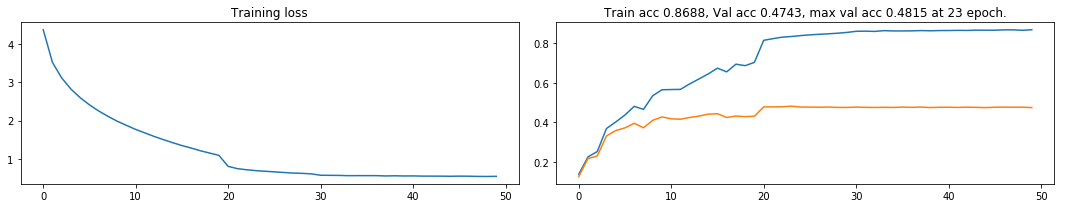

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:42:04<00:00, 194.52s/it]


In [8]:
set_random_seeds(device=device)
scheduler = torch.optim.lr_scheduler.MultiStepLR(adam_optimizer, (20, 30), gamma=.1)  
val_accuracy = train(model, adam_optimizer, train_size=len(data_train), batch_size=100, device=device, scheduler=scheduler, epochs_n=50, write = True, label = 'HW2_CNN')

When everything is done, please compute accuracy on the validation set and report it below.

# Report

Below, please mention

* a brief history of tweaks and improvements;
* what is the final architecture and why?
* what is the training method (batch size, optimization algorithm, ...) and why?
* Any regularization and other techniques applied and their effects;

The reference format is:

*"I have analyzed these and these articles|sources|blog posts, tried that and that to adapt them to my problem and the conclusions are such and such".*

Firstly, I have analyzed huge amount of arcticles and papers, devoted to ```tiny-ImageNet-200 Challenge``` and come up with the idea, that the most popular solutions are based on Neural Networks, that are good for solving this task (```ResNet, AlexNet, VGG, ...```) are already implemented in ```torchvision``` library. So the first idea was to implement ResNet, which was supposed to be very good without predtrained weights and finetuning, according to <http://cs231n.stanford.edu/reports/2017/pdfs/935.pdf>, using the class from ```torchvision```. But here come the problem: In most cases, this NN's are fitted to another size of image ($224 \times 224$ instead of $64 \times 64$), so the problem was to make either data augmentation resize of images or to recalculate the the parameters of NN. This was first milestone. After getting closer similar with this NN's I came up with the idea not to use the already implemented NN, but to make a new one from scratch. Let's load the written NN and validate it one more time:



In [15]:
#loading model from File
model.load_state_dict(torch.load('./HW2_CNN_best_params.pt'))
model.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace)
  (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (14): BatchNorm2d(256, eps=1e-05, 

In [16]:
print("Validation accuracy: %.2f%%" % (get_accuracy(model, val_loader, device) * 100))

Validation accuracy: 48.15%


So the resulting architecture of the represented above NN is the work of creating simple CNN, with ReLU activations (the most simple and effective activation function) then adding more convolutional layers and adding more parameters to NN. The output of last linear layer as it was done a hundred times comes from LogSoftMax (logarithm for numerical stability) and as metrics Cross Entropy is used.  After that I increased the performance of NN, by adding Batch Normalization, which significantly improved the accuracy. Then, when the final NN was build, I've chosed Adam optimizer, because from previous assignment I saw that it outperforms SGD. The another tweak in performance was to add steps for learning rate (my NN has different learning rates for epochs from 0 to 20, from 20 to 30 and from 30 to 50), which also supposed to improve the performance. 

After that all, there was also a hunt for accuracy, which was motivated by <http://cs231n.stanford.edu/reports/2017/pdfs/12.pdf>. In this paper was told, that every data augmentation improves the NN, so I applied some rotations, affine transformations, color and contrast transformations on the data. This is the final adjustment in performance. During the implementation, there were several usefull links, amonth them: <https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/5>, <https://gist.github.com/bveliqi/a847f955f2ec13d74d22c088c6f771b4> and of course, my ML's course assignments.

The results are significant: My CNN shows from scratch, without predtrained weights the following performance: accuracy validation = $48.15 \%$, accuracy training = $86.88 \%$, which are supposed to be enough for all assignment requirements. State with best validation accuracy is saved in file ```HW2_CNN_best_params.pt ```.